In [10]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy.modeling.models import Gaussian2D, Polynomial2D, Lorentz2D, Moffat2D, PowerLaw1D
from astropy.modeling import fitting, custom_model

from photutils.aperture import CircularAperture
from photutils.profiles import RadialProfile

from mmtwfs.wfs import check_wfsdata, wfsfind

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [3]:
spot = fits.open("spot.fits")[0].data

back = np.mean([spot[:2, :].mean(), spot[-2:, :].mean(), spot[:, :2].mean(), spot[:, -2:].mean()])
print(back)
spot -= back
g2d = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
l2d = Lorentz2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)
m2d = Moffat2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)

model = m2d
gmodel = g2d
fitter = fitting.DogBoxLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
gfit = fitter(gmodel, x, y, spot)

gsigma = 0.5 * (gfit.x_stddev.value + gfit.y_stddev.value)
#print(sigma)
print(fit.fwhm, gsigma * stats.gaussian_sigma_to_fwhm)

58533.5685483871
6.128661844095589 6.4321858255881255


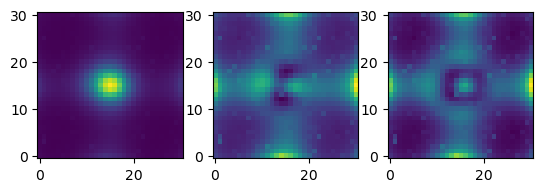

In [145]:
fig, ax = plt.subplots(1, 3)
im1 = ax[0].imshow(spot, origin='lower')
im2 = ax[1].imshow(spot - fit(x, y), origin='lower')
im2 = ax[2].imshow(spot - gfit(x, y), origin='lower')
plt.show()

In [150]:
@custom_model
def spot_profile(r, amplitude=1, a=1):
    return amplitude * np.exp(-a * r**(5/3))

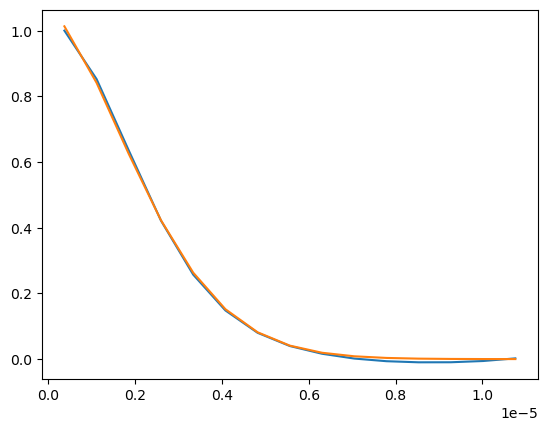

Parameter('amplitude', value=1.049714134785819) Parameter('a', value=1856176082.24205)


In [189]:
xycen = (spot.shape[1]/2, spot.shape[0]/2)
edge_radii = np.arange(np.max(xycen))
rp = RadialProfile(spot, xycen, edge_radii)
rp.normalize()
prof_model = spot_profile(amplitude=1, a=1e6)
#prof_model.amplitude.fixed = True
rad_ang = rp.radius * 0.153 / 206265
prof_fit = fitter(prof_model, rad_ang, rp.profile)
plt.plot(rad_ang, rp.profile)
plt.plot(rad_ang, prof_fit(rad_ang))
plt.show()
print(prof_fit.amplitude, prof_fit.a)

In [195]:
wave = 0.5e-6
r0 = wave / (3.44/prof_fit.a)**0.6
seeing_fwhm = 206265 * 0.976 * wave / r0
r0, seeing_fwhm

(np.float64(0.0867374084595355), np.float64(1.1604833691446796))

In [155]:
rp.gaussian_fwhm * 0.153

np.float64(0.9808730300188842)

In [137]:
ang_freq = 206265 / rad_ang

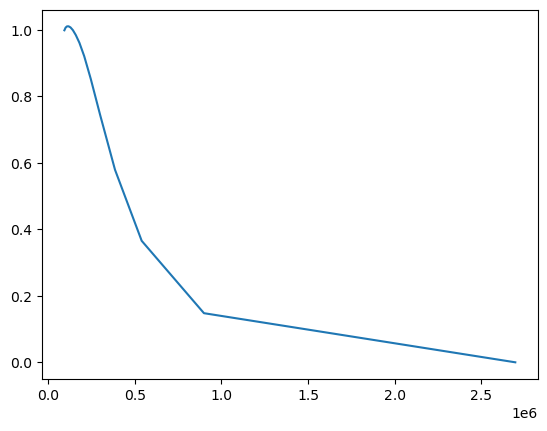

In [138]:
plt.plot(ang_freq, 1 - rp.profile)
plt.show()

In [135]:
@custom_model
def psf_profile(r, r0=0.1):
    return np.exp(-3.44 * (.5e-6*r/r0)**(5/3))

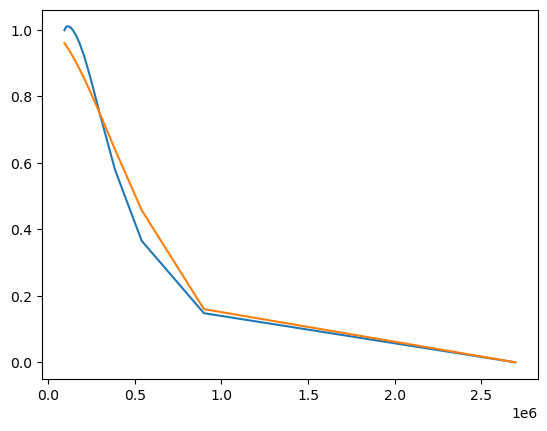

In [148]:
prof = psf_profile()
psf_fit = fitter(prof, ang_freq, 1 - rp.profile)
plt.plot(ang_freq, 1 - rp.profile)
plt.plot(ang_freq, psf_fit(ang_freq))
plt.show()

In [149]:
psf_fit.r0, 206265 * 0.976 * wave / psf_fit.r0

(Parameter('r0', value=0.6554395570536804), np.float64(0.15357223853328733))

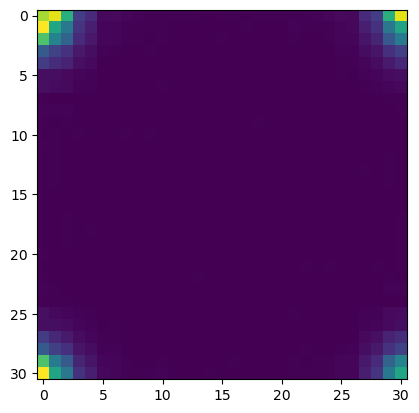

In [144]:
fft_im = np.fft.fft2(spot)
plt.imshow(np.abs(fft_im))
plt.show()